---
title: Downloading Climate Data from CHIRPS v3
short_title: CHIRPS v3 Climate Data
---

In this notebook we demonstrate how to fetch **CHIRPS v3 daily precipitation** for a DHIS2 organisation unit level, download only the needed spatial **bounding box**, and return an **xarray** object (ready for aggregation/analytics in a later step).

This notebook mirrors the ERA5-Land download flow, but uses CHIRPS v3 GeoTIFFs and raster window reads (no full global load).


--------------------------------------------
## What you need

We start by importing the necessary libraries:


In [1]:
import json
import geopandas as gpd

from dhis2_client import DHIS2Client
from dhis2_client.settings import ClientSettings

from dhis2eo.data.chc import chirps3

--------------------------------------------
## DHIS2 connection and organisation units

Configure DHIS2 and fetch org units (GeoJSON) for an admin level. The resulting GeoDataFrame is used to derive a bounding box.


In [2]:
# Client configuration
cfg = ClientSettings(
  base_url="http://localhost:9090",
  username="admin",
  password="district")

client = DHIS2Client(settings=cfg)
info = client.get_system_info()

# Check if everything is working.
# You should see your current DHIS2 version info.
print("▶ Current DHIS2 version:", info["version"])

▶ Current DHIS2 version: 2.43-SNAPSHOT


In [3]:
level = 2  # change as needed
org_units_geojson = client.get_org_units_geojson(level=level)

# Convert GeoJSON dict -> GeoDataFrame
org_units = gpd.read_file(json.dumps(org_units_geojson))
org_units

,id,code,name,level,parent,parentGraph,groups,geometry
0,O6uvpzGd5pu,OU_264,Bo,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy]","POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,fdc6uOvgoji,OU_193190,Bombali,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, J40PpdN4Wkk, GGghZsfu7qV]","POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,lc3eMKXaEfw,OU_197385,Bonthe,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy, GGghZsfu7qV]","MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,jUb8gELQApl,OU_204856,Kailahun,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, nlX2VoouN63]","POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,PMa2VCrupOd,OU_211212,Kambia,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, b0EsAxm8Nge, nlX2Vo...","MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,kJq2mPyFEHo,OU_222616,Kenema,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL]","POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,qhqAxPSTUXp,OU_226213,Koinadugu,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Vth0fbpFcsO,OU_233310,Kono,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,jmIPBj66vD6,OU_246990,Moyamba,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, jqBqIXoXpfy]","MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,TEQlaapDQoK,OU_254945,Port Loko,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, b0EsAxm8Nge]","MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


--------------------------------------------
## Download CHIRPS v3 daily precipitation for the org unit bounding box

We compute the bounding box from all org unit geometries and fetch CHIRPS v3 daily data clipped to that bbox.


In [4]:
bbox = tuple(org_units.total_bounds)  # (minx, miny, maxx, maxy)
bbox

(np.float64(-13.3035),
 np.float64(6.9176),
 np.float64(-10.2658),
 np.float64(10.0004))

In [5]:
# Choose a date range (inclusive)
start = "2025-07-01"
end = "2025-07-07"

ds = chirps3.daily.get(start=start, end=end, bbox=bbox)
ds

dhis2eo.data.chc.chirps3.daily - INFO - Fetching CHIRPS v3 daily from 2025-07-01 to 2025-07-07 (inclusive)
dhis2eo.data.chc.chirps3.daily - INFO - Stage/flavor: final/rnl
dhis2eo.data.chc.chirps3.daily - INFO - BBox: (np.float64(-13.3035), np.float64(6.9176), np.float64(-10.2658), np.float64(10.0004))
dhis2eo.data.chc.chirps3.daily - INFO - Reading 2025-07-01 -> https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/2025/chirps-v3.0.rnl.2025.07.01.tif
dhis2eo.data.chc.chirps3.daily - INFO - Reading 2025-07-02 -> https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/2025/chirps-v3.0.rnl.2025.07.02.tif
dhis2eo.data.chc.chirps3.daily - INFO - Reading 2025-07-03 -> https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/2025/chirps-v3.0.rnl.2025.07.03.tif
dhis2eo.data.chc.chirps3.daily - INFO - Reading 2025-07-04 -> https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/2025/chirps-v3.0.rnl.2025.07.04.tif
dhis2eo.data.chc.chirps3.daily - INFO - Reading 2025-

<xarray.Dataset> Size: 107kB
Dimensions:  (time: 7, y: 62, x: 61)
Coordinates:
  * time     (time) datetime64[ns] 56B 2025-07-01 2025-07-02 ... 2025-07-07
  * y        (y) float64 496B 9.975 9.925 9.875 9.825 ... 7.025 6.975 6.925
  * x        (x) float64 488B -13.27 -13.22 -13.17 ... -10.37 -10.32 -10.27
Data variables:
    precip   (time, y, x) float32 106kB ...
Attributes:
    bbox:     [-13.3035   6.9176 -10.2658  10.0004]
    dataset:  CHIRPS v3 (daily)
    stage:    final
    flavor:   rnl

In [6]:
# The main variable is precipitation (default name: 'precip')
ds['precip']

<xarray.DataArray 'precip' (time: 7, y: 62, x: 61)> Size: 106kB
[26474 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 56B 2025-07-01 2025-07-02 ... 2025-07-07
  * y        (y) float64 496B 9.975 9.925 9.875 9.825 ... 7.025 6.975 6.925
  * x        (x) float64 488B -13.27 -13.22 -13.17 ... -10.37 -10.32 -10.27
Attributes:
    crs:         EPSG:4326
    source_url:  https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/r...
    long_name:   Precipitation
    units:       mm/day

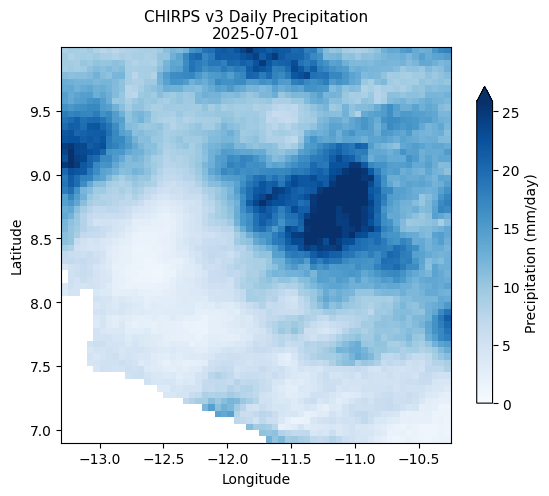

In [12]:
import matplotlib.pyplot as plt

precip = ds["precip"].where(ds["precip"] >= 0)

fig, ax = plt.subplots(figsize=(6, 5))

precip.isel(time=0).plot(
    ax=ax,
    cmap="Blues",
    vmin=0,
    robust=True,
    cbar_kwargs={
        "label": "Precipitation (mm/day)",
        "shrink": 0.8,
    },
)

ax.set_title("CHIRPS v3 Daily Precipitation\n2025-07-01", fontsize=11)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_aspect("equal", adjustable="box")
ax.grid(False)

plt.tight_layout()
plt.show()
